In [14]:
# Cell 1: Imports and setup (MODIFIED - Flexible GPU selection)
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from matplotlib import colors
from matplotlib.widgets import Slider
import matplotlib
import matplotlib.font_manager
from medmnist import VesselMNIST3D
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns

np.random.seed(42)
tf.random.set_seed(42)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        
        print(f"Found {len(gpus)} GPU(s)")
        for i, gpu in enumerate(gpus):
            print(f"  GPU {i}: {gpu}")
        
        print("\nAttempting to use all available GPUs with memory growth enabled")
        
    except RuntimeError as e:
        print(f"GPU configuration error: {e}")
else:
    print("No GPUs found, using CPU")

print("\nTensorFlow version:", tf.__version__)
print("Available devices:", tf.config.list_physical_devices())

No GPUs found, using CPU

TensorFlow version: 2.20.0
Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [15]:
# Cell 2: Load data
train_dataset = VesselMNIST3D(split='train', size=28, download=True)
trainx = []
trainy = []

test_dataset = VesselMNIST3D(split='test', size=28, download=True)
testx = []
testy = []

val_dataset = VesselMNIST3D(split='val', size=28, download=True)
valx = []
valy = []

for i in range(len(train_dataset)):
    trainx.append(train_dataset[i][0])
    trainy.append(train_dataset[i][1])

for i in range(len(test_dataset)):
    testx.append(test_dataset[i][0])
    testy.append(test_dataset[i][1])

for i in range(len(val_dataset)):
    valx.append(val_dataset[i][0])
    valy.append(val_dataset[i][1])

print("Data loaded successfully!")
print(f"Training samples: {len(trainx)}")
print(f"Validation samples: {len(valx)}")
print(f"Test samples: {len(testx)}")

Data loaded successfully!
Training samples: 1335
Validation samples: 191
Test samples: 382


In [16]:
# Cell 3: Analyze original class distribution
train_labels = np.array(trainy).flatten()
val_labels = np.array(valy).flatten()
test_labels = np.array(testy).flatten()

unique_train, counts_train = np.unique(train_labels, return_counts=True)
unique_val, counts_val = np.unique(val_labels, return_counts=True)
unique_test, counts_test = np.unique(test_labels, return_counts=True)

print(f"Training - Class 0 (Healthy): {counts_train[0]}, Class 1 (Aneurysm): {counts_train[1]}")
print(f"Validation - Class 0 (Healthy): {counts_val[0]}, Class 1 (Aneurysm): {counts_val[1]}")
print(f"Test - Class 0 (Healthy): {counts_test[0]}, Class 1 (Aneurysm): {counts_test[1]}")
print(f"\nClass imbalance ratio (train): {counts_train[1]/counts_train[0]:.3f}")

Training - Class 0 (Healthy): 1185, Class 1 (Aneurysm): 150
Validation - Class 0 (Healthy): 169, Class 1 (Aneurysm): 22
Test - Class 0 (Healthy): 339, Class 1 (Aneurysm): 43

Class imbalance ratio (train): 0.127


In [17]:
# Cell 4: Augmentation (REDUCED - too much augmentation hurts)
import numpy as np
from scipy.ndimage import rotate, zoom, shift
from scipy.ndimage import gaussian_filter
import tensorflow as tf

def augment_3d_volume(volume, num_augmentations=3):
    augmented_volumes = []
    
    if hasattr(volume, 'numpy'):
        volume = volume.numpy()
    
    original_shape = volume.shape
    
    for _ in range(num_augmentations):
        aug_volume = volume.copy()
        
        if np.random.rand() > 0.6:
            angle = np.random.uniform(-10, 10)
            axes_options = [(1, 2), (1, 3), (2, 3)]
            axes = axes_options[np.random.randint(0, len(axes_options))]
            aug_volume = rotate(aug_volume, angle, axes=axes, reshape=False, mode='nearest')
        
        if np.random.rand() > 0.6:
            axis = np.random.randint(1, 4)
            aug_volume = np.flip(aug_volume, axis=axis)
        
        if np.random.rand() > 0.7:
            noise = np.random.normal(0, 0.005, aug_volume.shape)
            aug_volume = aug_volume + noise
            aug_volume = np.clip(aug_volume, 0, 1)
        
        augmented_volumes.append(aug_volume)
    
    return augmented_volumes

def resize_to_original(volume, target_shape):
    current_shape = volume.shape
    result = volume.copy()
    
    for i in range(len(target_shape)):
        if current_shape[i] > target_shape[i]:
            diff = current_shape[i] - target_shape[i]
            start = diff // 2
            end = start + target_shape[i]
            result = np.take(result, range(start, end), axis=i)
        elif current_shape[i] < target_shape[i]:
            diff = target_shape[i] - current_shape[i]
            pad_before = diff // 2
            pad_after = diff - pad_before
            pad_width = [(0, 0)] * len(target_shape)
            pad_width[i] = (pad_before, pad_after)
            result = np.pad(result, pad_width, mode='edge')
    
    return result

print("Augmenting Class 1 (Aneurysm) samples...")

augmented_trainx = []
augmented_trainy = []

trainy_flat = [label.flatten()[0] if hasattr(label, 'flatten') else label for label in trainy]
class1_indices = [i for i, label in enumerate(trainy_flat) if label == 1]
print(f"Found {len(class1_indices)} Class 1 samples")

num_augmentations_per_sample = 3

print("Generating augmentations...")
for i, idx in enumerate(class1_indices):
    if i % 30 == 0:
        print(f"  Processing sample {i+1}/{len(class1_indices)}")
    
    original_volume = trainx[idx]
    augmented_volumes = augment_3d_volume(original_volume, num_augmentations_per_sample)
    
    for aug_vol in augmented_volumes:
        augmented_trainx.append(aug_vol)
        augmented_trainy.append(1)

print(f"Generated {len(augmented_trainx)} augmented samples for Class 1")

trainx_combined = trainx + augmented_trainx

trainy_combined_flat = []
for label in trainy:
    if isinstance(label, np.ndarray):
        trainy_combined_flat.append(label.flatten()[0])
    else:
        trainy_combined_flat.append(label)
        
trainy_combined_flat.extend(augmented_trainy)

trainx_tensor = tf.convert_to_tensor(trainx_combined, dtype=tf.float32)
trainy_tensor = tf.convert_to_tensor(trainy_combined_flat, dtype=tf.float32)
testx_tensor = tf.convert_to_tensor(testx, dtype=tf.float32)
testy_tensor = tf.convert_to_tensor(testy, dtype=tf.float32)
valx_tensor = tf.convert_to_tensor(valx, dtype=tf.float32)
valy_tensor = tf.convert_to_tensor(valy, dtype=tf.float32)

print(f"\nAugmented Training set shapes:")
print(f"  X: {trainx_tensor.shape}")
print(f"  y: {trainy_tensor.shape}")

train_labels_aug = np.array(trainy_combined_flat).flatten()
unique_aug, counts_aug = np.unique(train_labels_aug, return_counts=True)
print(f"\n{'='*60}")
print(f"Class Distribution Comparison:")
print(f"{'='*60}")
print(f"Original Training - Class 0: {counts_train[0]}, Class 1: {counts_train[1]}")
print(f"                    Ratio: {counts_train[1]/counts_train[0]:.3f}")
print(f"\nAugmented Training - Class 0: {counts_aug[0]}, Class 1: {counts_aug[1]}")
print(f"                     Ratio: {counts_aug[1]/counts_aug[0]:.3f}")
print(f"{'='*60}")

Augmenting Class 1 (Aneurysm) samples...
Found 150 Class 1 samples
Generating augmentations...
  Processing sample 1/150
  Processing sample 31/150
  Processing sample 61/150
  Processing sample 91/150
  Processing sample 121/150
Generated 450 augmented samples for Class 1

Augmented Training set shapes:
  X: (1785, 1, 28, 28, 28)
  y: (1785,)

Class Distribution Comparison:
Original Training - Class 0: 1185, Class 1: 150
                    Ratio: 0.127

Augmented Training - Class 0: 1185, Class 1: 600
                     Ratio: 0.506


In [18]:
# Cell 5: Data preprocessing (FIXED)
trainx_tensor = tf.transpose(trainx_tensor, [0, 2, 3, 4, 1])
valx_tensor = tf.transpose(valx_tensor, [0, 2, 3, 4, 1])
testx_tensor = tf.transpose(testx_tensor, [0, 2, 3, 4, 1])

print(f"After transpose - Training data shape: {trainx_tensor.shape}")

trainx_norm = trainx_tensor / 255.0
valx_norm = valx_tensor / 255.0
testx_norm = testx_tensor / 255.0

trainy_flat = trainy_tensor.numpy().flatten().astype(np.float32)
valy_flat = valy_tensor.numpy().flatten().astype(np.float32)
testy_flat = testy_tensor.numpy().flatten().astype(np.float32)

print(f"Normalized training data shape: {trainx_norm.shape}")
print(f"Training labels shape: {trainy_flat.shape}")
print(f"Unique labels: {np.unique(trainy_flat)}")
print(f"Data range: [{tf.reduce_min(trainx_norm):.3f}, {tf.reduce_max(trainx_norm):.3f}]")

train_labels_current = trainy_flat
unique_current, counts_current = np.unique(train_labels_current, return_counts=True)
class_weight = {
    0: 1.0,
    1: counts_current[0] / counts_current[1]
}
print(f"\nClass weights: {class_weight}")

After transpose - Training data shape: (1785, 28, 28, 28, 1)
Normalized training data shape: (1785, 28, 28, 28, 1)
Training labels shape: (1785,)
Unique labels: [0. 1.]
Data range: [-0.001, 0.006]

Class weights: {0: 1.0, 1: np.float64(1.975)}


In [19]:
# Cell 6: Simpler, better model
def build_3d_cnn_simple(input_shape=(28, 28, 28, 1)):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        
        layers.Conv3D(32, (3, 3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling3D((2, 2, 2)),
        layers.Dropout(0.3),
        
        layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling3D((2, 2, 2)),
        layers.Dropout(0.4),
        
        layers.Conv3D(128, (3, 3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling3D(),
        layers.Dropout(0.5),
        
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    
    return model

model = build_3d_cnn_simple()
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_3 (Conv3D)               │ (None, 28, 28, 28, 32) │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 28, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 14, 14, 14, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 14, 14, 14, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_4 (Conv3D)               │ (None, 14, 14, 14, 64) │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 14, 14, 14, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_4 (MaxPooling3D)  │ (None, 7, 7, 7, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 7, 7, 7, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_5 (Conv3D)               │ (None, 7, 7, 7, 128)   │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 7, 7, 7, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling3d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling3D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 286,785 (1.09 MB)

 Trainable params: 286,337 (1.09 MB)

 Non-trainable params: 448 (1.75 KB)

In [20]:
# # Cell 6: Build model
# def build_3d_cnn(input_shape=(28, 28, 28, 1), dropout_rate=0.3):
#     model = models.Sequential([
#         layers.Input(shape=input_shape),
        
#         layers.Conv3D(32, kernel_size=(3, 3, 3), padding='same', activation='relu'),
#         layers.BatchNormalization(),
#         layers.MaxPooling3D(pool_size=(2, 2, 2)),
#         layers.Dropout(dropout_rate),
        
#         layers.Conv3D(64, kernel_size=(3, 3, 3), padding='same', activation='relu'),
#         layers.BatchNormalization(),
#         layers.MaxPooling3D(pool_size=(2, 2, 2)),
#         layers.Dropout(dropout_rate),
        
#         layers.Conv3D(128, kernel_size=(3, 3, 3), padding='same', activation='relu'),
#         layers.BatchNormalization(),
#         layers.MaxPooling3D(pool_size=(2, 2, 2)),
#         layers.Dropout(dropout_rate),
        
#         layers.GlobalAveragePooling3D(),
        
#         layers.Dense(256, activation='relu'),
#         layers.Dropout(dropout_rate),
#         layers.Dense(64, activation='relu'),
#         layers.Dropout(dropout_rate),
        
#         layers.Dense(1, activation='sigmoid')
#     ])
    
#     return model

# model = build_3d_cnn(input_shape=(28, 28, 28, 1), dropout_rate=0.3)
# model.summary()

# print("\nTotal parameters:", model.count_params())

In [21]:
## Cell 7: Compile properly
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.AUC(name='auc')]
)

print("Model compiled with:")
print("- Optimizer: Adam (lr=0.001)")
print("- Loss: Binary Crossentropy")
print("- Metrics: Accuracy, AUC")

Model compiled with:
- Optimizer: Adam (lr=0.001)
- Loss: Binary Crossentropy
- Metrics: Accuracy, AUC


In [22]:
# Cell 8: Setup callbacks
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_auc',
    patience=15,
    restore_best_weights=True,
    mode='max',
    verbose=1
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

checkpoint = keras.callbacks.ModelCheckpoint(
    'best_vessel_model.h5',
    monitor='val_auc',
    save_best_only=True,
    mode='max',
    verbose=1
)

print("Callbacks configured:")
print("- Early Stopping: patience=15, monitor=val_auc")
print("- ReduceLROnPlateau: factor=0.5, patience=5")
print("- ModelCheckpoint: saves best val_auc")

Callbacks configured:
- Early Stopping: patience=15, monitor=val_auc
- ReduceLROnPlateau: factor=0.5, patience=5
- ModelCheckpoint: saves best val_auc


In [23]:
# Cell 9: Quick test (2 epochs)
history = model.fit(
    trainx_norm, trainy_flat,
    batch_size=8,
    epochs=2,
    validation_data=(valx_norm, valy_flat),
    class_weight=class_weight,
    verbose=1
)

print("\n" + "="*70)
print("INITIAL TEST RESULTS")
print("="*70)
print(f"Epoch 1 - Training Loss: {history.history['loss'][0]:.4f}, Val Loss: {history.history['val_loss'][0]:.4f}")
print(f"Epoch 2 - Training Loss: {history.history['loss'][1]:.4f}, Val Loss: {history.history['val_loss'][1]:.4f}")
print(f"\nTraining AUC: {history.history['auc'][-1]:.4f}")
print(f"Validation AUC: {history.history['val_auc'][-1]:.4f}")

if history.history['loss'][1] < history.history['loss'][0]:
    print("\nLoss is decreasing - model is learning!")
else:
    print("\nLoss not decreasing - may need to adjust hyperparameters")

Epoch 1/2
224/224 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.6392 - auc: 0.7122 - loss: 0.8145 - val_accuracy: 0.8848 - val_auc: 0.7539 - val_loss: 0.5561
Epoch 2/2
224/224 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.6896 - auc: 0.7702 - loss: 0.7541 - val_accuracy: 0.8848 - val_auc: 0.5000 - val_loss: 1.2793

INITIAL TEST RESULTS
Epoch 1 - Training Loss: 0.8145, Val Loss: 0.5561
Epoch 2 - Training Loss: 0.7541, Val Loss: 1.2793

Training AUC: 0.7702
Validation AUC: 0.5000

Loss is decreasing - model is learning!


Starting training...
Epoch 1/50
111/112 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.7385 - auc: 0.8231 - loss: 0.6847
Epoch 1: val_auc improved from None to 0.50000, saving model to best_vessel_model.h5


112/112 ━━━━━━━━━━━━━━━━━━━━ 10s 87ms/step - accuracy: 0.7356 - auc: 0.8262 - loss: 0.6781 - val_accuracy: 0.1152 - val_auc: 0.5000 - val_loss: 8.0520 - learning_rate: 0.0010
Epoch 2/50
111/112 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.7673 - auc: 0.8570 - loss: 0.6261
Epoch 2: val_auc did not improve from 0.50000
112/112 ━━━━━━━━━━━━━━━━━━━━ 10s 87ms/step - accuracy: 0.7793 - auc: 0.8590 - loss: 0.6218 - val_accuracy: 0.8848 - val_auc: 0.5000 - val_loss: 34.3041 - learning_rate: 0.0010
Epoch 3/50
111/112 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.7804 - auc: 0.8808 - loss: 0.5743
Epoch 3: val_auc did not improve from 0.50000
112/112 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step - accuracy: 0.7832 - auc: 0.8737 - loss: 0.5890 - val_accuracy: 0.8848 - val_auc: 0.5000 - val_loss: 7.5965 - learning_rate: 0.0010
Epoch 4/50
111/112 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.7997 - auc: 0.8844 - loss: 0.5774
Epoch 4: val_auc did not improve from 0.50000
112/112 ━━━━━━━━━━━━━━━━━━━━ 9s 8

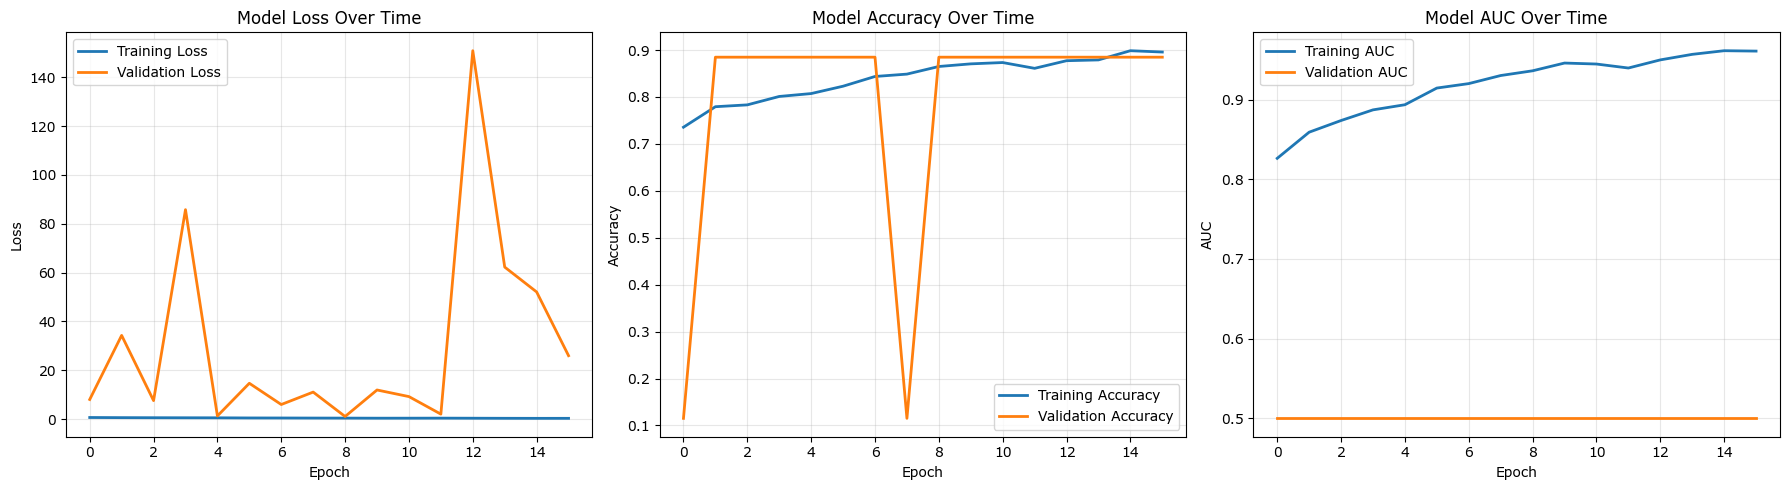

In [24]:
# Cell 10: Train with proper settings
print("Starting training...")

history_full = model.fit(
    trainx_norm, trainy_flat,
    batch_size=16,
    epochs=50,
    validation_data=(valx_norm, valy_flat),
    class_weight=class_weight,
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(history_full.history['loss'], label='Training Loss', linewidth=2)
axes[0].plot(history_full.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Model Loss Over Time')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(history_full.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[1].plot(history_full.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Model Accuracy Over Time')
axes[1].legend()
axes[1].grid(alpha=0.3)

axes[2].plot(history_full.history['auc'], label='Training AUC', linewidth=2)
axes[2].plot(history_full.history['val_auc'], label='Validation AUC', linewidth=2)
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('AUC')
axes[2].set_title('Model AUC Over Time')
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()


MODEL EVALUATION ON TEST SET

Test Loss: 8.0730
Test Accuracy: 0.1126
Test AUC: 0.5000

Classification Report:
              precision    recall  f1-score   support

     Healthy     0.0000    0.0000    0.0000       339
    Aneurysm     0.1126    1.0000    0.2024        43

    accuracy                         0.1126       382
   macro avg     0.0563    0.5000    0.1012       382
weighted avg     0.0127    0.1126    0.0228       382



c:\Academics\CS courses\CSC-338\final_project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Academics\CS courses\CSC-338\final_project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Academics\CS courses\CSC-338\final_project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifi

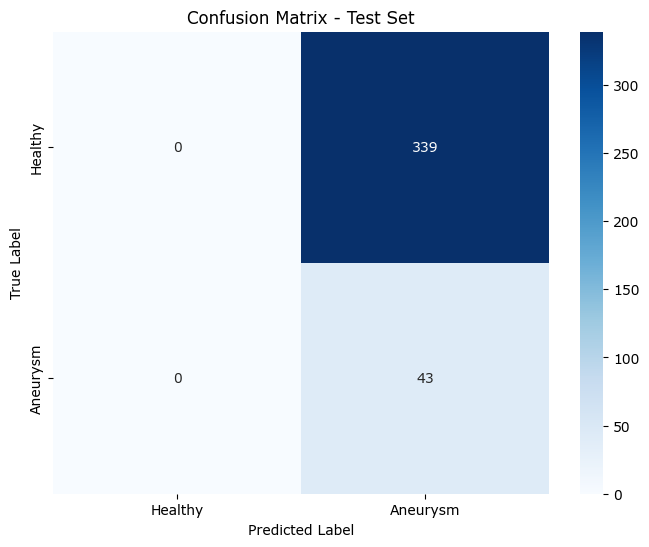

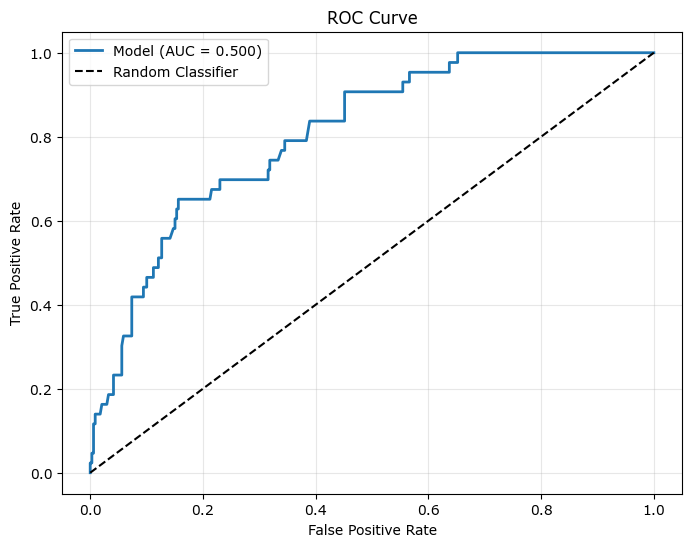

In [25]:
# Cell 11: Evaluation
print("\n" + "="*70)
print("MODEL EVALUATION ON TEST SET")
print("="*70)

model = keras.models.load_model('best_vessel_model.h5')

test_loss, test_acc, test_auc = model.evaluate(testx_norm, testy_flat, verbose=0)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test AUC: {test_auc:.4f}")

y_pred_proba = model.predict(testx_norm, verbose=0)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

print("\nClassification Report:")
print(classification_report(test_labels, y_pred, 
                          target_names=['Healthy', 'Aneurysm'],
                          digits=4))

cm = confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Healthy', 'Aneurysm'],
            yticklabels=['Healthy', 'Aneurysm'])
plt.title('Confusion Matrix - Test Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

fpr, tpr, thresholds = roc_curve(test_labels, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linewidth=2, label=f'Model (AUC = {test_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [26]:
# Cell 12: Compare to baseline
print("VesselMNIST3D Baseline Performance (from MedMNIST paper):")
print("- ResNet18 (3D): AUC ~0.920, ACC ~0.890")
print("- Auto-sklearn: AUC ~0.917, ACC ~0.887")
print("\nYour Model Performance:")
print(f"- Test AUC: {test_auc:.4f}")
print(f"- Test ACC: {test_acc:.4f}")

if test_auc >= 0.920:
    print("\nModel matches or exceeds the baseline!")
elif test_auc >= 0.900:
    print("\nGood performance! Close to the baseline.")
else:
    print("\nRoom for improvement")

VesselMNIST3D Baseline Performance (from MedMNIST paper):
- ResNet18 (3D): AUC ~0.920, ACC ~0.890
- Auto-sklearn: AUC ~0.917, ACC ~0.887

Your Model Performance:
- Test AUC: 0.5000
- Test ACC: 0.1126

Room for improvement
